This notebook further refines the files generated by filter_2_code.py by removing identical translations of the same term in different contexts, as they do not provide significant value to the study (if they are translated the same, there is no ambiguity, even if their meaning is different).

## LIBRARIES

In [8]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
from collections import Counter  # For counting occurrences
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations
from matplotlib.colors import LinearSegmentedColormap  # For custom color maps
import os  # For file and directory operations
import re # Importing the regex library

## PATHS AND CODES

In [9]:
# Paths to the CSV files (adjust the paths according to the location of your files)
csv_paths = {
    "EN_ES": '../filter_2_strict_polysemy/generated_files/EN_ES_filtered_extra.csv',
    "ES_EN": '../filter_2_strict_polysemy/generated_files/ES_EN_filtered_extra.csv',
    "EN_EU": '../filter_2_strict_polysemy/generated_files/EN_BA_filtered_extra.csv',
    "EU_EN": '../filter_2_strict_polysemy/generated_files/BA_EN_filtered_extra.csv',
    "ES_EU": '../filter_2_strict_polysemy/generated_files/ES_BA_filtered_extra.csv',
    "EU_ES": '../filter_2_strict_polysemy/generated_files/BA_ES_filtered_extra.csv'
}

# Load CSV files into DataFrames
# Ensure that the column names are consistent across all DataFrames
original_dataframes = {}
for key, path in csv_paths.items():
    try:
        df = pd.read_csv(path)
        df.columns = ['term', 'translation', 'context']  # Standardize column names
        original_dataframes[key] = df
    except FileNotFoundError:
        print(f"File not found: {path}")
    except Exception as e:
        print(f"Error loading {path}: {e}")

# Unpack the DataFrames into individual variables for compatibility with existing code
df_en_es = original_dataframes.get("EN_ES")
df_es_en = original_dataframes.get("ES_EN")
df_en_eu = original_dataframes.get("EN_EU")
df_eu_en = original_dataframes.get("EU_EN")
df_es_eu = original_dataframes.get("ES_EU")
df_eu_es = original_dataframes.get("EU_ES")

## CODE TO EXTRACT THE 10 MOST FREQUENT PAIRS BY LANGUAGE AND SAVE THEM IN FOLDERS

In [10]:
# List of DataFrames, their names, and destination folders
dataframes_info = [
    (df_en_es, "EN-ES", 'pair_lists/EN_ES/'),
    (df_es_en, "ES-EN", 'pair_lists/ES_EN/'),
    (df_en_eu, "EN-BA", 'pair_lists/EN_BA/'),
    (df_eu_en, "BA-EN", 'pair_lists/BA_EN/'),
    (df_es_eu, "ES-BA", 'pair_lists/ES_BA/'),
    (df_eu_es, "BA-ES", 'pair_lists/BA_ES/')
]

def sanitize_filename(filename):
    # Replace any invalid characters for file names
    return re.sub(r'[<>:"/\\|?*]', '~', filename)

def extract_term_contexts(dataframe):
    """
    Extracts unique contexts and translations for each term in the DataFrame.

    Args:
        dataframe (pd.DataFrame): Input DataFrame with columns 'term', 'context', and 'translation'.

    Returns:
        dict: A dictionary where keys are terms, and values are dictionaries of contexts and their translations.
    """
    term_contexts = {}
    for _, row in dataframe.iterrows():
        term = row['term']
        context = row['context']
        translation = row['translation']

        if term not in term_contexts:
            term_contexts[term] = {}
        if context not in term_contexts[term]:
            term_contexts[term][context] = set()

        term_contexts[term][context].add(translation)

    return term_contexts

def process_and_save_pairs(dataframe, pair_name, output_folder):
    """
    Processes a DataFrame to find context pairs with different translations and saves the results.

    Args:
        dataframe (pd.DataFrame): Input DataFrame with columns 'term', 'context', and 'translation'.
        pair_name (str): Name of the language pair (e.g., "EN-ES").
        output_folder (str): Path to the folder where results will be saved.
    """
    os.makedirs(output_folder, exist_ok=True)
    print(f"\nProcessing {pair_name}...")
    print(f"Output folder: {output_folder}")

    term_contexts = extract_term_contexts(dataframe)

    # Count pairs of contexts with different translations
    pair_counter = Counter()

    for term, contexts in term_contexts.items():
        context_list = list(contexts.keys())
        for i in range(len(context_list)):
            for j in range(i + 1, len(context_list)):
                context1, context2 = context_list[i], context_list[j]
                translations1 = contexts[context1]
                translations2 = contexts[context2]

                # Filter pairs where one translation is a subset of the other
                is_subset = any(
                    t1 in t2 or t2 in t1
                    for t1 in translations1
                    for t2 in translations2
                )

                # Check for parts separated by ';'
                if not is_subset:
                    is_subset = any(
                        part1.strip() in [p.strip() for p in list(translations2)[0].split(';')]
                        for part1 in [p.strip() for p in list(translations1)[0].split(';')]
                    ) or any(
                        part2.strip() in [p.strip() for p in list(translations1)[0].split(';')]
                        for part2 in [p.strip() for p in list(translations2)[0].split(';')]
                    )

                # Count only if translations are different and not subsets
                if translations1 != translations2 and not is_subset:
                    pair = tuple(sorted([context1, context2]))  # Ensure consistent pair order
                    pair_counter[pair] += 1

    # Get the 10 most frequent pairs for this DataFrame
    top_10_pairs = pair_counter.most_common(10)

    # Display the 10 most frequent pairs
    print(f"\nTop 10 most frequent pairs in {pair_name}:")
    for pair, count in top_10_pairs:
        print(f"Pair: {pair}, Occurrences: {count}")

        # Save files for this pair
        context1, context2 = pair
        output_file = os.path.join(output_folder, f"[{sanitize_filename(context1)}]_and_[{sanitize_filename(context2)}].csv")

        data_to_save = []
        for term, contexts in term_contexts.items():
            if context1 in contexts and context2 in contexts:
                translations1 = contexts[context1]
                translations2 = contexts[context2]

                # Verify that translations are not subsets
                is_subset = any(
                    t1 in t2 or t2 in t1
                    for t1 in translations1
                    for t2 in translations2
                )

                # Check for parts separated by ';'
                if not is_subset:
                    is_subset = any(
                        part1.strip() in [p.strip() for p in list(translations2)[0].split(';')]
                        for part1 in [p.strip() for p in list(translations1)[0].split(';')]
                    ) or any(
                        part2.strip() in [p.strip() for p in list(translations1)[0].split(';')]
                        for part2 in [p.strip() for p in list(translations2)[0].split(';')]
                    )

                if translations1 != translations2 and not is_subset:
                    for translation1 in translations1:
                        data_to_save.append([term, translation1, context1])
                    for translation2 in translations2:
                        data_to_save.append([term, translation2, context2])

        if data_to_save:
            df_output = pd.DataFrame(data_to_save, columns=['Term', 'Translation', 'Context'])
            df_output.to_csv(output_file, index=False, encoding='utf-8')
            print(f"  File saved: {output_file} (contains {len(data_to_save)} rows)")
        else:
            print(f"  No data found for pair: {context1} and {context2}")

#Uncomment the following lines to process all DataFrames
for df, name, folder in dataframes_info:
     process_and_save_pairs(df, name, folder)


Processing EN-ES...
Output folder: pair_lists/EN_ES/

Top 10 most frequent pairs in EN-ES:
Pair: ('Technological Sciences > Environmental technology and engineering', 'Technological Sciences > Projects'), Occurrences: 22
  File saved: pair_lists/EN_ES/[Technological Sciences ~ Environmental technology and engineering]_and_[Technological Sciences ~ Projects].csv (contains 44 rows)
Pair: ('Technological Sciences > Industrial technology', 'Technological Sciences > Mechanical engineering and technology'), Occurrences: 21
  File saved: pair_lists/EN_ES/[Technological Sciences ~ Industrial technology]_and_[Technological Sciences ~ Mechanical engineering and technology].csv (contains 42 rows)
Pair: ('Earth and Space Sciences > Geology', 'Technological Sciences > Environmental technology and engineering'), Occurrences: 20
  File saved: pair_lists/EN_ES/[Earth and Space Sciences ~ Geology]_and_[Technological Sciences ~ Environmental technology and engineering].csv (contains 40 rows)
Pair: ('Ph

## GRAPHS

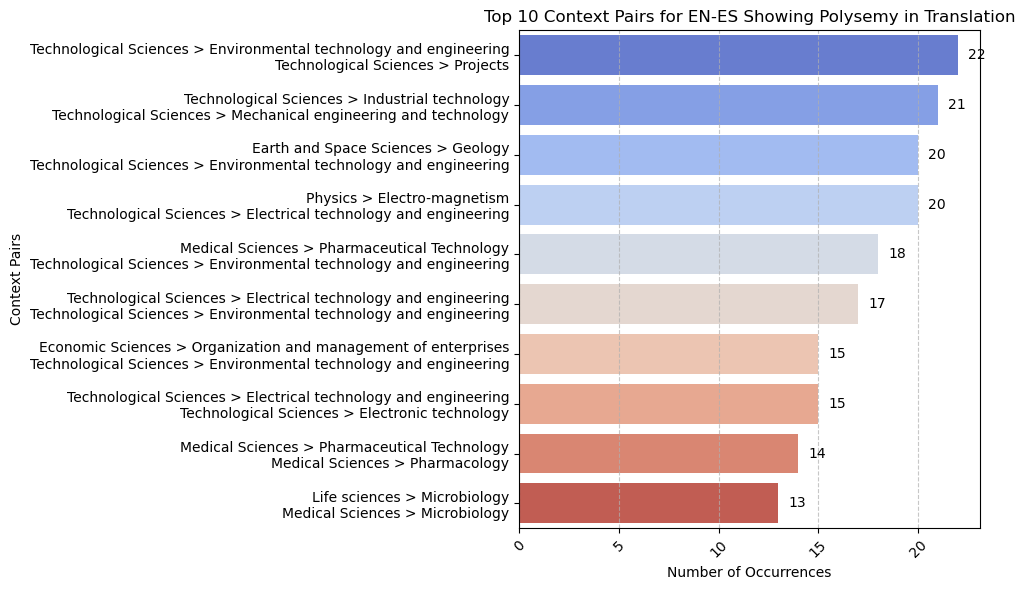

Plot saved: pair_graphics/top_10_pairs_EN-ES.png


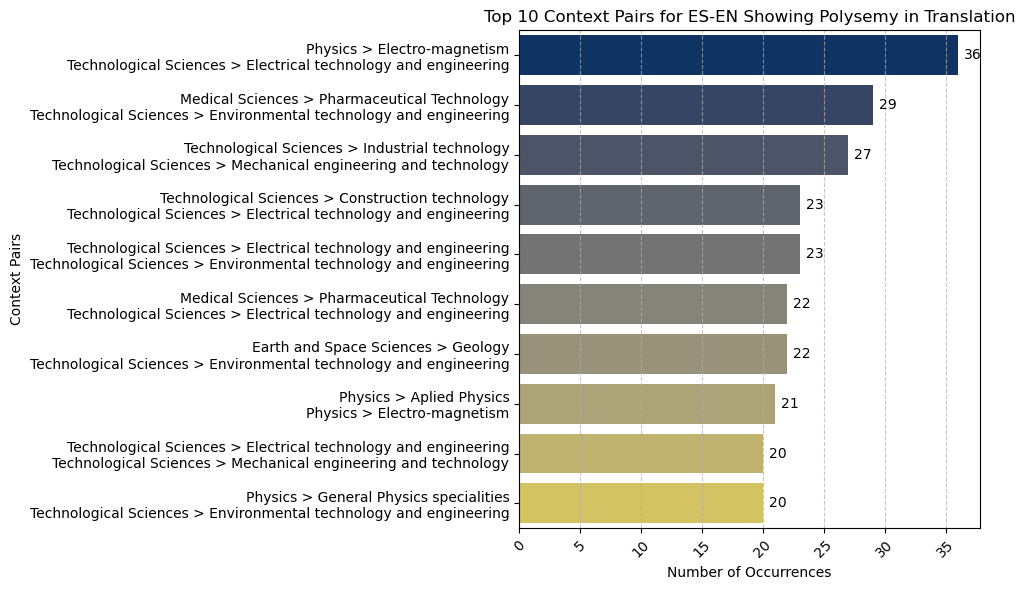

Plot saved: pair_graphics/top_10_pairs_ES-EN.png


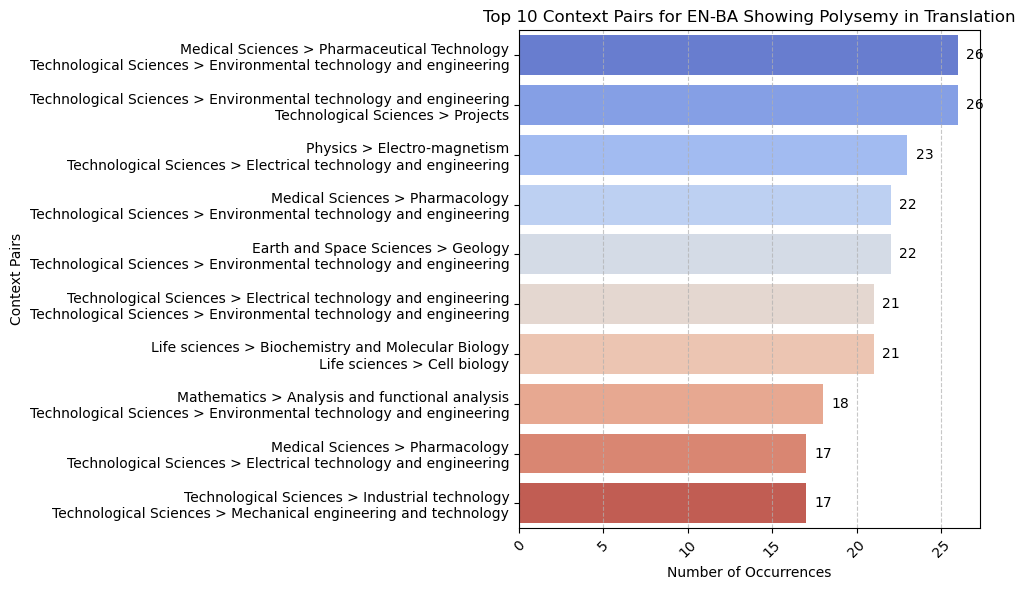

Plot saved: pair_graphics/top_10_pairs_EN-BA.png


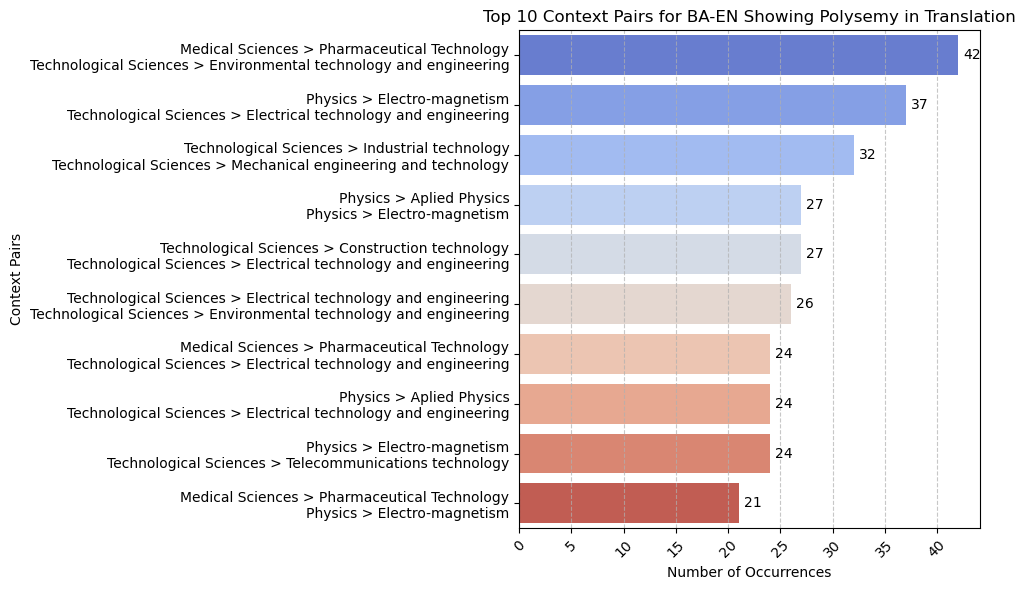

Plot saved: pair_graphics/top_10_pairs_BA-EN.png


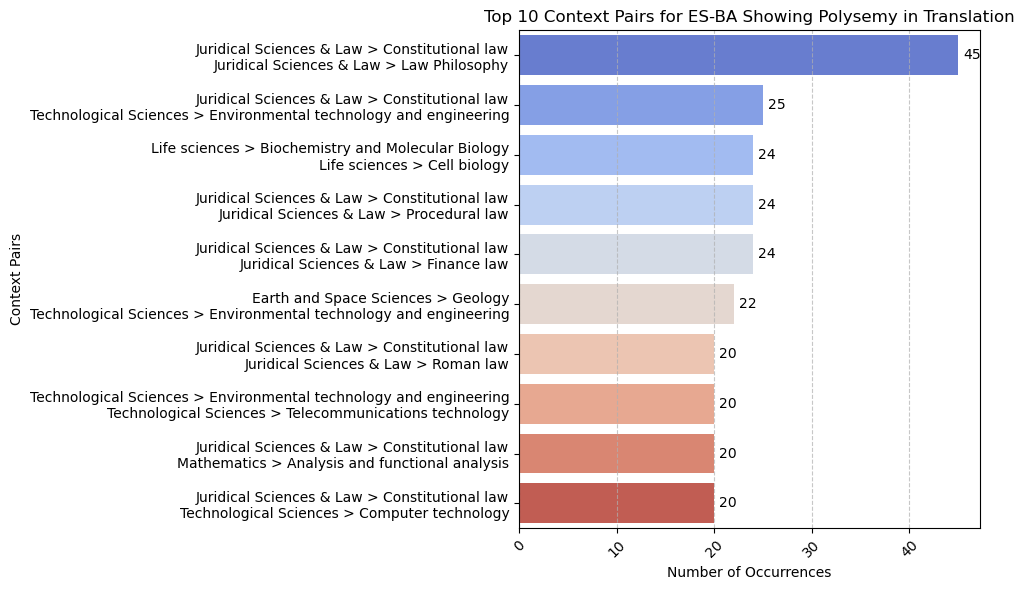

Plot saved: pair_graphics/top_10_pairs_ES-BA.png


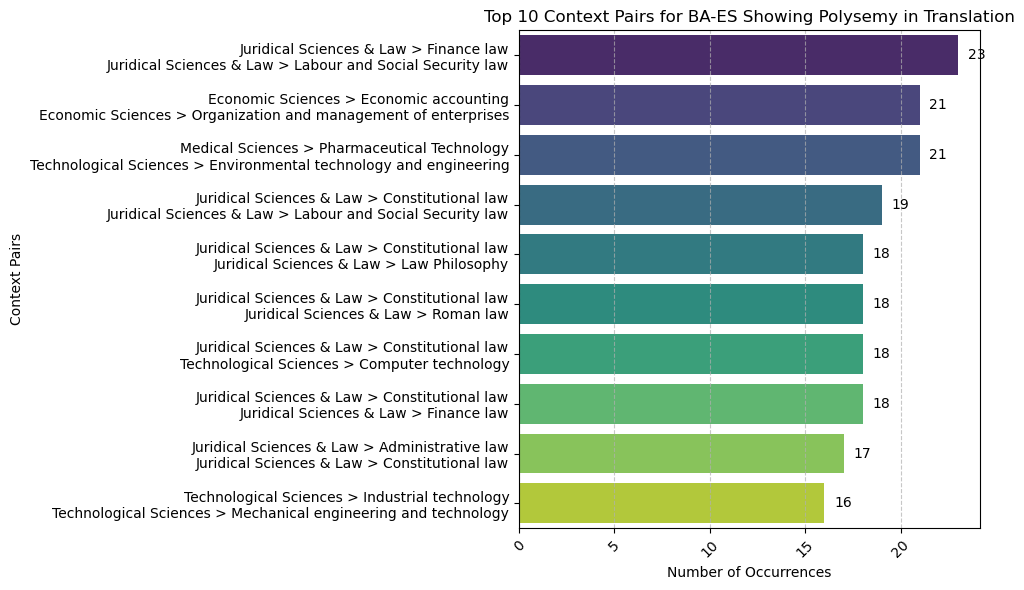

Plot saved: pair_graphics/top_10_pairs_BA-ES.png


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# Define a list of color palettes to vary across graphs
color_palettes = ["viridis", "magma", "plasma", "cividis", "coolwarm", "Spectral"]

# Define the directory to save the plots
output_directory = 'pair_graphics/'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

def plot_top_context_pairs(top_pairs, language_pair_name):
    """
    Generates and saves a bar chart for the top 10 most frequent context pairs.

    Args:
        top_pairs (list): A list of tuples containing context pairs and their counts.
        language_pair_name (str): The name of the language pair (e.g., "EN-ES").
    """
    if not top_pairs:
        print(f"Not enough data for {language_pair_name}")
        return

    # Unpack pairs and counts
    pairs, counts = zip(*top_pairs)

    # Convert tuple pairs to readable strings
    pair_labels = [f"{p[0]}\n{p[1]}" for p in pairs]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    selected_palette = random.choice(color_palettes)  # Select a random color palette
    ax = sns.barplot(y=pair_labels, x=counts, hue=pair_labels, palette=selected_palette, dodge=False)

    # Annotate bars with their counts
    for i, count in enumerate(counts):
        ax.text(count + 0.5, i, str(count), color='black', va='center')

    # Add labels and title
    plt.xlabel("Number of Occurrences")
    plt.ylabel("Context Pairs")
    plt.title(f"Top 10 Context Pairs for {language_pair_name} Showing Polysemy in Translation", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Adjust layout and save the plot
    plt.tight_layout()
    file_path = os.path.join(output_directory, f"top_10_pairs_{language_pair_name}.png")
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved: {file_path}")

# Process each DataFrame and generate plots
for dataframe, language_pair_name, _ in dataframes_info:
    term_contexts = extract_term_contexts(dataframe)  # Reuse the existing function
    context_pair_counter = Counter()

    # Iterate through terms and their contexts
    for term, contexts in term_contexts.items():
        context_list = list(contexts.keys())
        for i in range(len(context_list)):
            for j in range(i + 1, len(context_list)):
                context1, context2 = context_list[i], context_list[j]
                translations1 = contexts[context1]
                translations2 = contexts[context2]

                # Check if one translation is a subset of the other
                is_subset = any(
                    t1 in t2 or t2 in t1
                    for t1 in translations1
                    for t2 in translations2
                )

                # Check for partial matches separated by ';'
                if not is_subset:
                    is_subset = any(
                        part1.strip() in [p.strip() for p in list(translations2)[0].split(';')]
                        for part1 in [p.strip() for p in list(translations1)[0].split(';')]
                    ) or any(
                        part2.strip() in [p.strip() for p in list(translations1)[0].split(';')]
                        for part2 in [p.strip() for p in list(translations2)[0].split(';')]
                    )

                # Count the pair if translations are different and not subsets
                if translations1 != translations2 and not is_subset:
                    pair = tuple(sorted([context1, context2]))  # Ensure consistent pair order
                    context_pair_counter[pair] += 1

    # Get the top 10 most frequent pairs and plot them
    top_10_context_pairs = context_pair_counter.most_common(10)
    plot_top_context_pairs(top_10_context_pairs, language_pair_name)
